In [1]:
from utils import evaluate_policy, str2bool, Actor, Q_Critic, ReplayBuffer, test_policy
from datetime import datetime
import gymnasium as gym
import os, shutil
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
import random
import numpy as np
import copy
import math
from collections import deque

from torch.distributions import Beta,Normal

In [2]:
def get_args():
    # 创建命令行参数解析器
    parser = argparse.ArgumentParser()

    # 添加各种命令行参数
    parser.add_argument('--algo_name',default='DDPO',type=str,help="算法名")
    parser.add_argument('--dvc', type=str, default='cuda', help='运行设备: cuda 或 cpu')
    parser.add_argument('--env_name', type=str, default='InvertedDoublePendulum-v4', help='环境名')
    parser.add_argument('--render_mode', type=str, default='rgb_array', help='环境渲染模式')
    parser.add_argument('--write', type=str2bool, default=True, help='使用SummaryWriter记录训练')
    parser.add_argument('--render', type=str2bool, default=False, help='是否渲染')
    parser.add_argument('--Loadmodel', type=str2bool, default=False, help='是否加载预训练模型')
    parser.add_argument('--ModelIdex', type=int, default=2350000, help='要加载的模型索引')
    parser.add_argument('--deque_maxlen',default=20,type=int)

    parser.add_argument('--seed', type=int, default=1, help='随机种子')
    parser.add_argument('--Max_train_steps', type=int, default=5e7, help='最大训练步数')
    parser.add_argument('--save_interval', type=int, default=5e4, help='模型保存间隔，以步为单位')
    parser.add_argument('--eval_interval', type=int, default=2e3, help='模型评估间隔，以步为单位')
    parser.add_argument('--test_interval', type=int, default=5e4, help='视频保存间隔，以步为单位')

    parser.add_argument('--gamma', type=float, default=0.99, help='折扣因子')
    parser.add_argument('--net_width', type=int, default=256, help='隐藏网络宽度')
    parser.add_argument('--a_lr', type=float, default=1e-3, help='Learning rate of actor')
    parser.add_argument('--c_lr', type=float, default=1e-3, help='Learning rate of critic')
    parser.add_argument('--batch_size', type=int, default=128, help='切片轨迹的长度')
    parser.add_argument('--random_steps', type=int, default=5e4, help='random steps before trianing')
    parser.add_argument('--noise', type=float, default=0.1, help='exploring noise')
    parser.add_argument('--tau', type=float, default=0.005, help='soft update tau')
    
    # 解析命令行参数
    args = parser.parse_args([])
    args = {**vars(args)}  # 转换成字典类型    
    
    return args

In [3]:
def print_args(args):
    ## 打印超参数
    print("超参数")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in args.items():
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))  

In [4]:
def all_seed(env, seed):
    """
    设置随机种子以确保实验的可重复性

    参数:
    - env: Gym 环境，用于训练模型
    - seed: 随机种子值

    说明:
    1. 使用给定的随机种子设置 NumPy、Python、PyTorch 和 CUDA 的随机生成器。
    2. 禁用 CUDA 的非确定性操作以确保实验结果的一致性。
    """

    np.random.seed(seed)  # 设置 NumPy 随机种子
    random.seed(seed)  # 设置 Python 随机种子
    torch.manual_seed(seed)  # 设置 PyTorch 随机种子
    torch.cuda.manual_seed(seed)  # 设置 PyTorch CUDA 随机种子
    os.environ['PYTHONHASHSEED'] = str(seed)  # 设置 Python Hash 随机种子
    torch.backends.cudnn.deterministic = True  # 禁用 CUDA 非确定性操作以确保实验结果的一致性
    torch.backends.cudnn.benchmark = False  # 禁用 CUDA 非确定性操作以确保实验结果的一致性
    torch.backends.cudnn.enabled = False  # 禁用 CUDA 非确定性操作以确保实验结果的一致性

In [5]:
class DDPG_agent():
    def __init__(self, kwargs):
        self.__dict__.update(kwargs)

        self.actor = Actor(self.state_dim, self.action_dim, self.net_width, self.max_action).to(self.dvc)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.a_lr)
        self.actor_target = copy.deepcopy(self.actor)

        self.q_critic = Q_Critic(self.state_dim, self.action_dim, self.net_width).to(self.dvc)
        self.q_critic_optimizer = torch.optim.Adam(self.q_critic.parameters(), lr=self.c_lr)
        self.q_critic_target = copy.deepcopy(self.q_critic)

        self.replay_buffer = ReplayBuffer(self.state_dim, self.action_dim, max_size=int(5e5), dvc=self.dvc)

    def select_action(self, state, deterministic):
        """
        选择动作

        参数:
        - state: 当前状态
        - deterministic: 是否使用确定性策略选择动作

        返回:
        - 动作

        说明:
        1. 将状态从 [x, x, ..., x] 转换为 [[x, x, ..., x]]。
        2. 通过 Actor 网络获取动作。
        3. 如果是确定性策略，则直接返回动作。
        4. 如果是非确定性策略，则添加噪声并返回，确保在动作范围内。
        """
        with torch.no_grad():
            state = torch.FloatTensor(state[np.newaxis, :]).to(self.dvc)  # 1. 将状态转换为网络输入格式
            a = self.actor(state).cpu().numpy()[0]  # 2. 获取动作

            if deterministic:
                return a  # 3. 返回动作（确定性策略）

            else:
                noise = np.random.normal(0, self.max_action * self.noise, size=self.action_dim)  # 4. 生成噪声
                return (a + noise).clip(-self.max_action, self.max_action)  # 5. 添加噪声并确保在动作范围内
        
    def train(self):
        """
        训练方法

        说明:
        1. 从经验回放缓冲区中采样一批数据，包括当前状态(s)、动作(a)、奖励(r)、下一个状态(s_next)和终止标志(dw)。
        2. 使用目标策略网络(actor_target)预测下一个状态的动作(target_a_next)。
        3. 使用目标评论网络(q_critic_target)计算目标Q值(target_Q)。
        4. 计算目标Q值，考虑折扣因子(gamma)和终止标志(dw)。
        5. 计算当前评论网络(q_critic)的Q值(current_Q)。
        6. 计算Q值损失(q_loss)并执行评论网络优化。
        7. 计算动作损失(a_loss)并执行策略网络优化。
        8. 更新目标评论网络和目标策略网络参数，使用软更新策略。

        注意:
        - 该方法执行了一次深度强化学习的训练迭代。
        """
        with torch.no_grad():
            s, a, r, s_next, dw = self.replay_buffer.sample(self.batch_size)  # 1. 采样经验数据
            target_a_next = self.actor_target(s_next)  # 2. 预测下一个状态的动作
            target_Q = self.q_critic_target(s_next, target_a_next)  # 3. 计算目标Q值
            target_Q = r + (~dw) * self.gamma * target_Q  # 4. 计算目标Q值，考虑折扣因子和终止标志

        current_Q = self.q_critic(s, a)  # 5. 计算当前评论网络的Q值

        q_loss = F.mse_loss(current_Q, target_Q)  # 6. 计算Q值损失

        self.q_critic_optimizer.zero_grad()
        q_loss.backward()
        self.q_critic_optimizer.step()  # 6. 执行评论网络优化

        a_loss = -self.q_critic(s, self.actor(s)).mean()  # 7. 计算动作损失
        self.actor_optimizer.zero_grad()
        a_loss.backward()
        self.actor_optimizer.step()  # 7. 执行策略网络优化

        with torch.no_grad():
            for param, target_param in zip(self.q_critic.parameters(), self.q_critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)  # 8. 更新目标网络参数，使用软更新策略
        
        return a_loss, q_loss

    def save(self, episode):
        """
        保存当前训练模型的Actor和Critic参数到文件

        参数:
        - episode: 当前训练的episode数，用于在文件名中标识不同的保存点
        """
        model_path = f"model/{cfg['path']}"
        # 检查是否存在'model'文件夹，如果不存在则创建
        try:
            os.makedirs(model_path)
        except FileExistsError:
            pass
        # 保存Critic的参数到文件
        torch.save(self.q_critic.state_dict(), f"{model_path}/ddpg_critic{episode}.pth")
        # 保存Actor的参数到文件
        torch.save(self.actor.state_dict(), f"{model_path}/ppo_actor{episode}.pth")

    def load(self, episode):
        """
        从文件加载之前保存的Actor和Critic参数

        参数:
        - episode: 要加载的保存点的episode数
        """
        model_path = f"model/{cfg['path']}"
        # 加载之前保存的Critic的参数
        self.q_critic.load_state_dict(torch.load(f"{model_path}/ddpg_critic{episode}.pth"))
        # 加载之前保存的Actor的参数
        self.actor.load_state_dict(torch.load(f"{model_path}/ppo_actor{episode}.pth"))

In [6]:
def env_agent_config(cfg, path):
    """
    配置环境和代理

    参数:
    - cfg: 包含配置信息的字典
    - path: 模型保存路径

    返回:
    - env: Gym 环境
    - agent: PPO 代理

    说明:
    1. 创建指定环境并设置渲染模式。
    2. 如果配置中设置了种子，则为环境设置种子。
    3. 获取环境的状态空间维度和动作空间维度。
    4. 更新配置字典中的状态维度和动作维度。
    5. 创建 PPO 代理。

    注意:
    - PPO 代理的创建依赖于配置信息和模型保存路径。
    """
    env = gym.make(cfg['env_name'], render_mode=cfg['render_mode'])  # 1. 创建环境
    eval_env = gym.make(cfg['env_name'], render_mode=cfg['render_mode'])
    if cfg['seed'] != 0:
        all_seed(env, seed=cfg['seed'])  # 2. 如果配置中设置了种子，则为环境设置种子

    n_states = env.observation_space.shape[0]  # 3. 获取状态空间维度
    n_actions = env.action_space.shape[0]  # 获取动作空间维度
    max_action = float(env.action_space.high[0]) # 获取动作空间的最大值
    max_e_steps = env._max_episode_steps  # 最大步数
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}，最大步数：{max_e_steps}")
    cfg.update({"state_dim": n_states, "action_dim": n_actions, "max_e_steps": max_e_steps, "max_action": max_action})  # 4. 更新n_states和n_actions到cfg参数中

    agent = DDPG_agent(cfg)  # 5. 创建 PPO 代理
    return env, eval_env, agent

In [7]:
cfg = get_args()

path = f"device:{cfg['dvc']}/{cfg['env_name']}/seed:{cfg['seed']}/{cfg['algo_name']}/net_width-{cfg['net_width']}-gamma-{cfg['gamma']}-a_lr-{cfg['a_lr']}-c_lr-{cfg['c_lr']}-batch_size-{cfg['batch_size']}"
cfg.update({"path":path}) # 更新n_states和n_actions到cfg参数中

base_dir = f"log/{cfg['path']}"

env, eval_env, agent = env_agent_config(cfg, path)

cfg.update({"mean_break":10e10})

print_args(cfg)

状态空间维度：11，动作空间维度：1，最大步数：1000
超参数
        Name        	       Value        	        Type        
     algo_name      	        DDPO        	   <class 'str'>    
        dvc         	        cuda        	   <class 'str'>    
      env_name      	InvertedDoublePendulum-v4	   <class 'str'>    
    render_mode     	     rgb_array      	   <class 'str'>    
       write        	         1          	   <class 'bool'>   
       render       	         0          	   <class 'bool'>   
     Loadmodel      	         0          	   <class 'bool'>   
     ModelIdex      	      2350000       	   <class 'int'>    
    deque_maxlen    	         20         	   <class 'int'>    
        seed        	         1          	   <class 'int'>    
  Max_train_steps   	     50000000.0     	  <class 'float'>   
   save_interval    	      50000.0       	  <class 'float'>   
   eval_interval    	       2000.0       	  <class 'float'>   
   test_interval    	      50000.0       	  <class 'float'>   
       gamma     

In [8]:
def train(cfg):
    print("开始训练")
    env_seed = cfg['seed']
    # 使用TensorBoard记录训练曲线
    if cfg['write']:
        writepath = 'runs/{}'.format(cfg['path']) # 构建TensorBoard日志路径
        if os.path.exists(writepath): shutil.rmtree(writepath)  # 如果路径已存在，则删除该路径及其内容
        writer = SummaryWriter(log_dir=writepath)  # 创建TensorBoard写入器，指定日志路径

    # 如果指定了加载模型的选项，则加载模型
    if cfg['Loadmodel']:
        print("加载模型")
        agent.load(cfg['ModelIdex'])

    # 如果选择渲染模式
    if cfg['render']:
        while True:
            # 在环境中评估智能体的性能，并输出奖励
            ep_r = evaluate_policy(env, agent, turns=1)
            print('Env: ', cfg['env_name'],' Episode Reward: ', {ep_r})
    else:
        total_steps = 0
        scores_deque = deque(maxlen=cfg['deque_maxlen'])

        # 在达到最大训练步数前一直进行训练
        while total_steps < cfg['Max_train_steps']:
            # 重置环境，获取初始状态
            s, info = env.reset(seed=env_seed)  # 重置环境，使用环境种子
            env_seed += 1
            done = False

            # 与环境进行交互并训练
            while not done:
                if total_steps < cfg['random_steps']:
                    a = env.action_space.sample()
                else:
                    a = agent.select_action(s, deterministic=False)
                # 选择动作和动作对应的对数概率
                s_next, r, dw, tr, info = env.step(a) # 与环境交互
                done = (dw or tr)  # 如果游戏结束（死亡或胜利），则done为True

                # 存储当前的转移数据
                agent.replay_buffer.add(s, a, r, s_next, dw)
                s = s_next
                total_steps += 1

                # 如果达到更新时间
                if total_steps >= cfg['random_steps']:
                    a_loss, c_loss = agent.train()  # 执行PPO算法的训练步骤
                    if cfg['write']:
                        writer.add_scalar('Loss_a', np.mean(a_loss.detach().cpu().numpy()), global_step=total_steps)
                        writer.add_scalar('Loss_c', np.mean(c_loss.detach().cpu().numpy()), global_step=total_steps)

                # 如果达到记录和日志的时间
                if (total_steps % cfg['eval_interval'] == 0) and (total_steps >= cfg['random_steps']):
                    # 在评估环境中评估智能体，并输出平均奖励
                    score = evaluate_policy(eval_env, agent, turns=3, cfg=cfg)  # 对策略进行3次评估，取平均值
                    scores_deque.append(score)
                    if cfg['write']:
                        writer.add_scalar('Score_ep', score, global_step=total_steps)  # 将评估得分记录到TensorBoard
                        writer.add_scalar('Score_Average', np.mean(scores_deque), global_step=total_steps)
                    print('EnvName:', cfg['env_name'], 'seed:', cfg['seed'],
                          'steps: {}k'.format(int(total_steps / 1000)), 'score:', score)
                    
                if (total_steps % cfg['test_interval'] == 0) and (total_steps >= cfg['random_steps']):
                    print("测试模型")
                    test_policy(eval_env, agent, total_steps, turns=1, path=cfg['path'], cfg=cfg)

                # 如果达到保存模型的时间
                if (total_steps % cfg['save_interval']  == 0) and (total_steps >= cfg['random_steps']):
                    print("保存模型")
                    agent.save(total_steps)  # 保存模型

                if (np.mean(scores_deque) >= cfg['mean_break']) and (len(scores_deque) >= cfg['deque_maxlen']):
                    print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(total_steps, np.mean(scores_deque)))
                    test_policy(eval_env, agent, total_steps, turns=1, path=cfg['path'], cfg=cfg)
                    print("保存模型")
                    agent.save(total_steps)
                    env.close()
                    eval_env.close()
                    return

        env.close()
        eval_env.close()

开始训练


/home/q1001p/anaconda3/envs/DRL_3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/q1001p/anaconda3/envs/DRL_3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 50k score: 32
测试模型
保存视频
保存模型
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 52k score: 92
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 54k score: 125
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 56k score: 165
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 58k score: 156
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 60k score: 181
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 62k score: 187
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 64k score: 227
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 66k score: 186
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 68k score: 103
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 70k score: 196
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 72k score: 119
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 74k score: 255
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 76k score: 202
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 78k score: 184
EnvName: Inv

/home/q1001p/Python/DRL/PG/DDPG/utils.py:219: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(frames[0].shape[1]/72, frames[0].shape[0]/72), dpi=72)


保存模型
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1052k score: 209
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1054k score: 97
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1056k score: 88
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1058k score: 166
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1060k score: 147
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1062k score: 150
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1064k score: 164
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1066k score: 165
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1068k score: 181
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1070k score: 100
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1072k score: 116
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1074k score: 196
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1076k score: 131
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1078k score: 127
EnvName: InvertedDoublePendulum-v4 seed: 1 steps: 1080k sco

KeyboardInterrupt: 

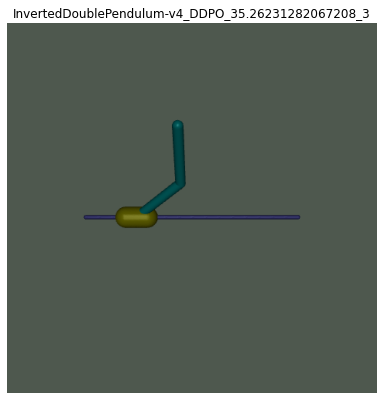

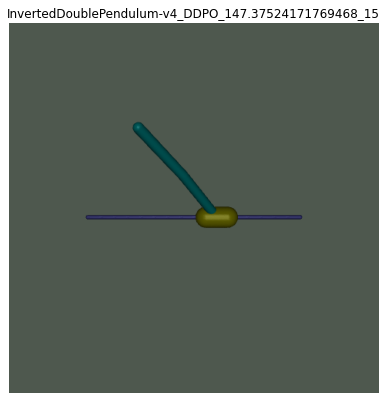

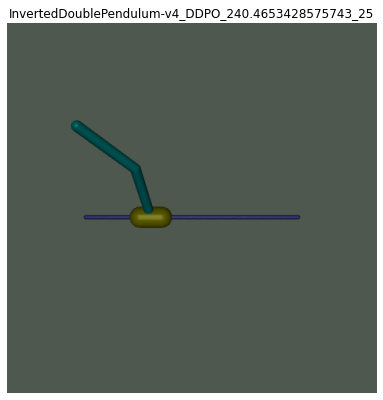

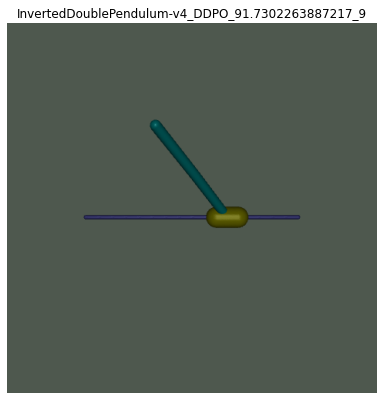

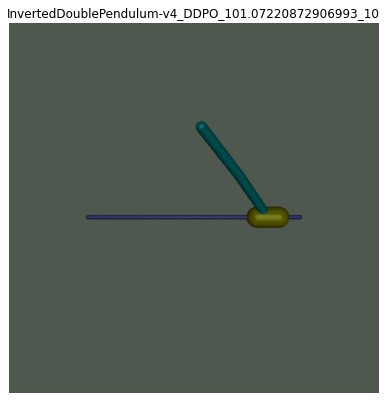

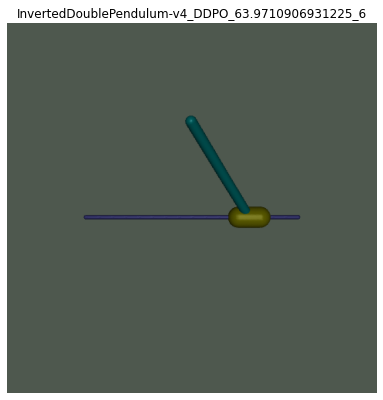

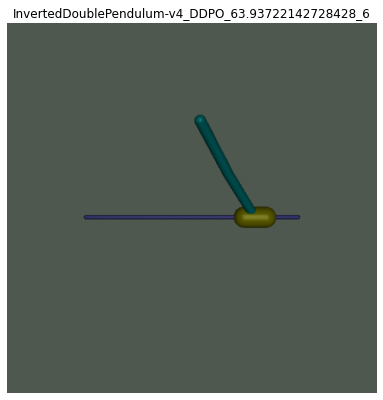

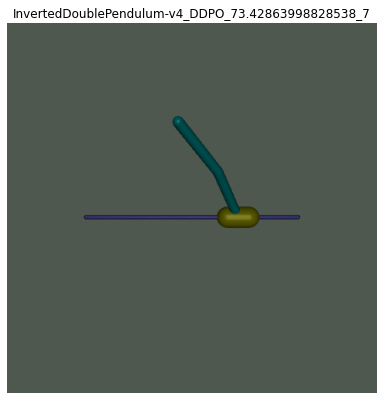

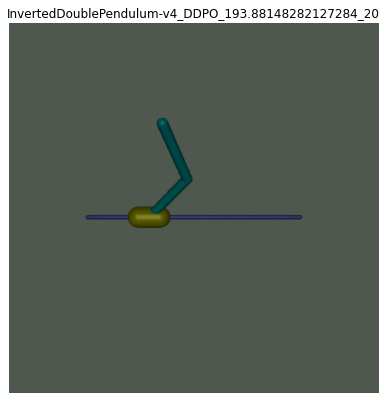

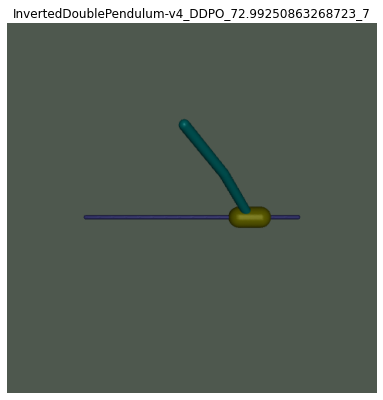

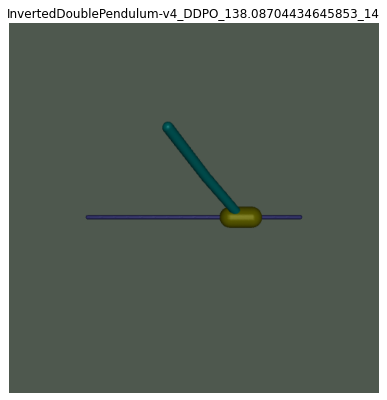

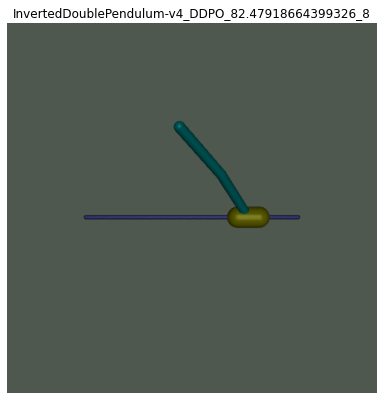

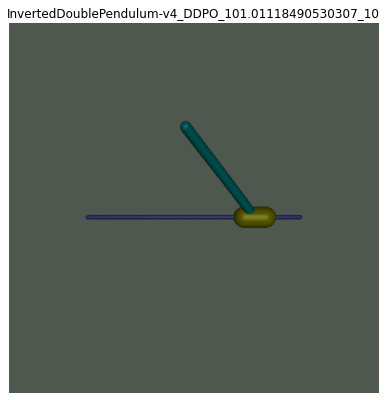

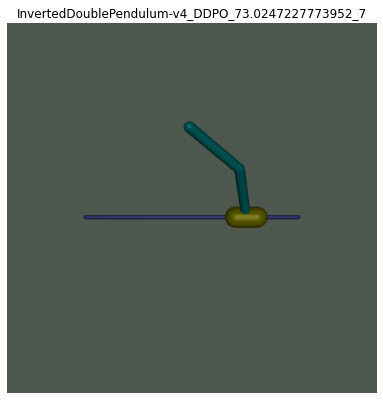

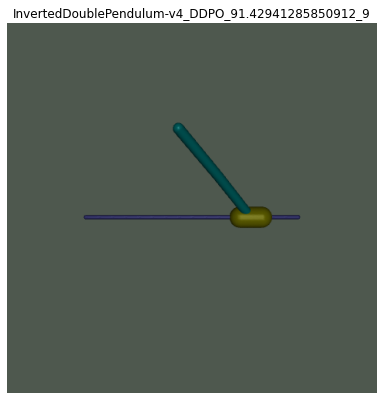

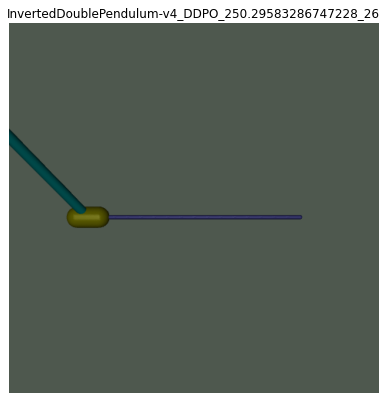

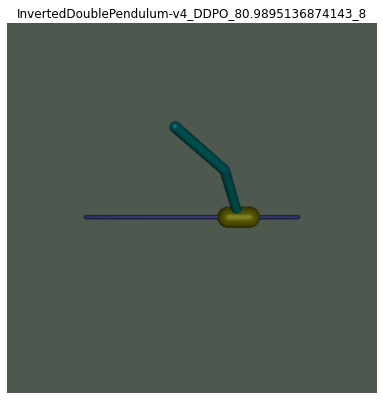

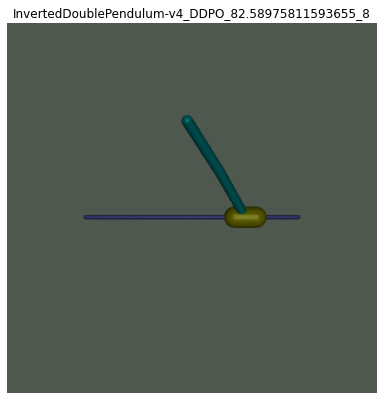

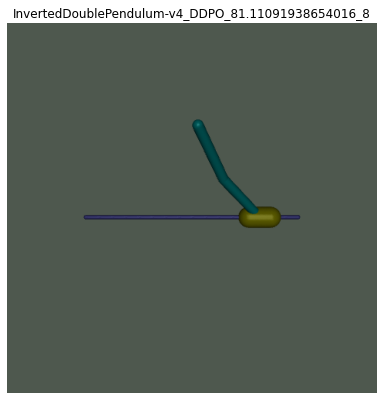

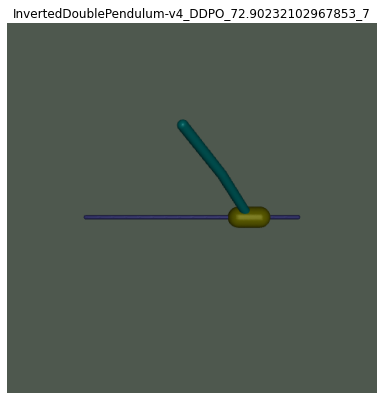

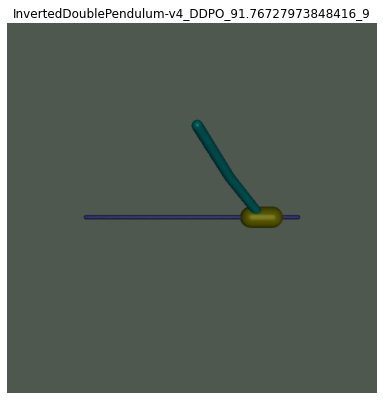

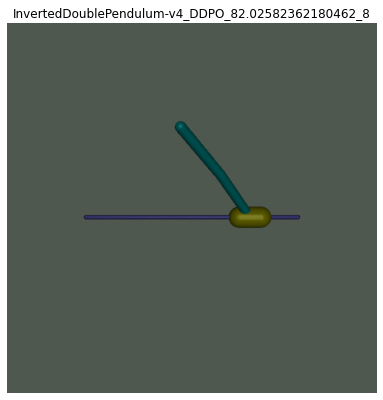

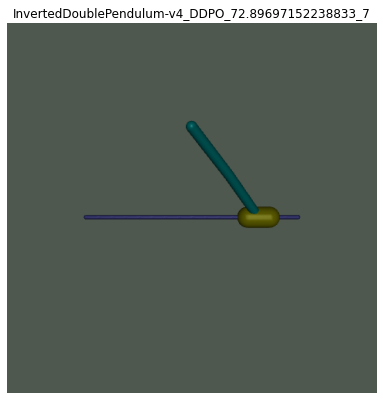

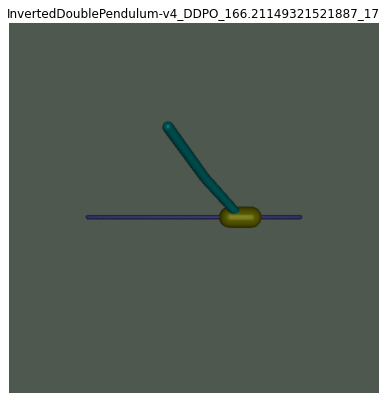

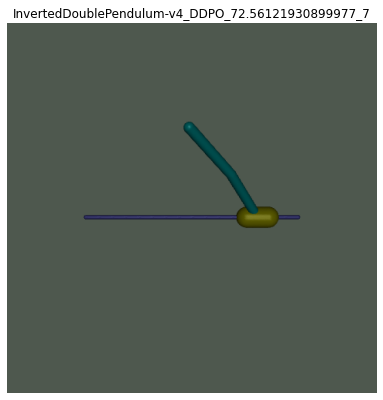

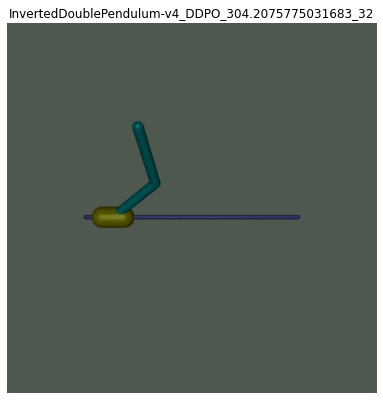

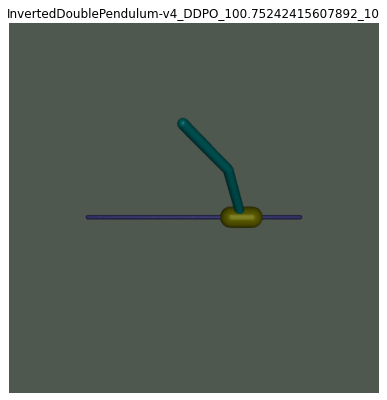

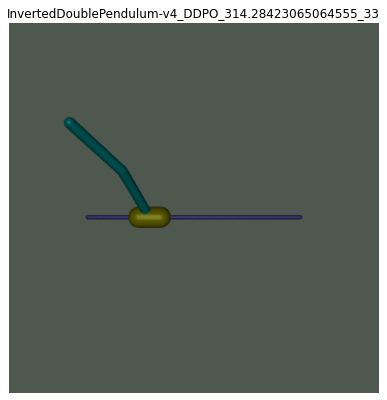

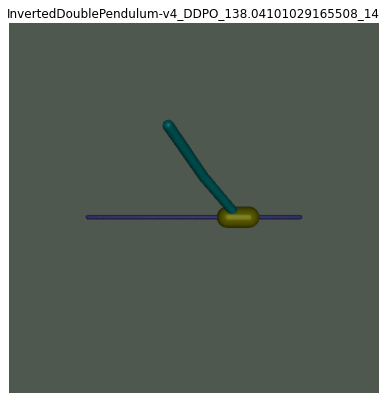

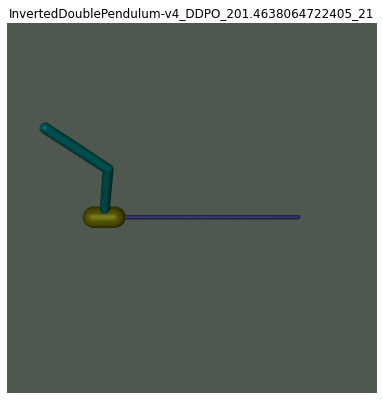

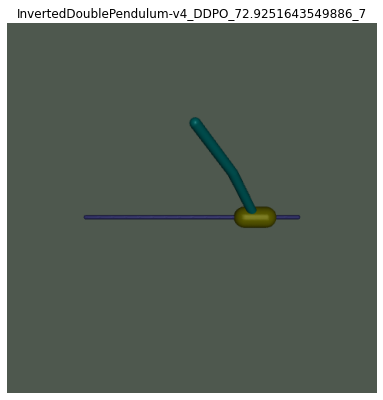

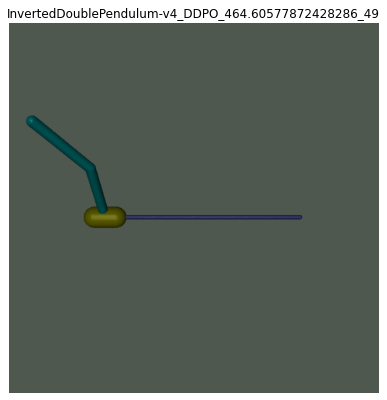

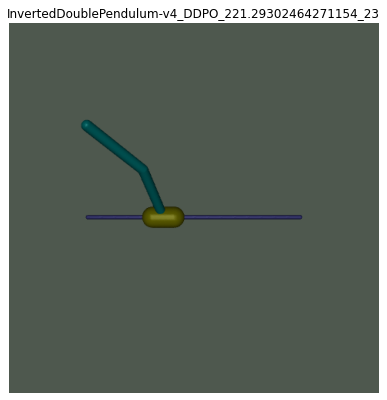

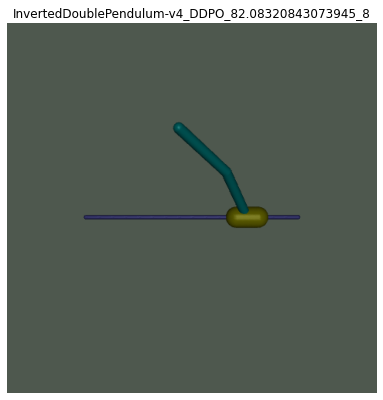

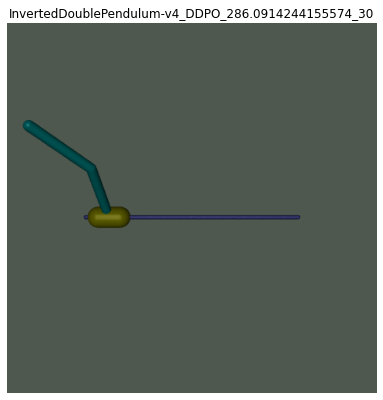

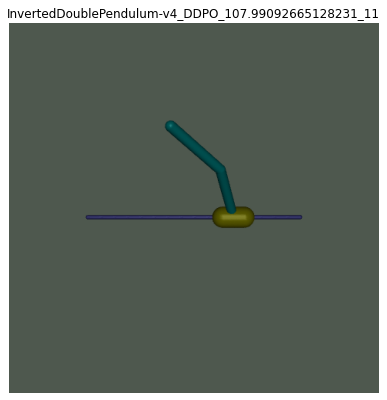

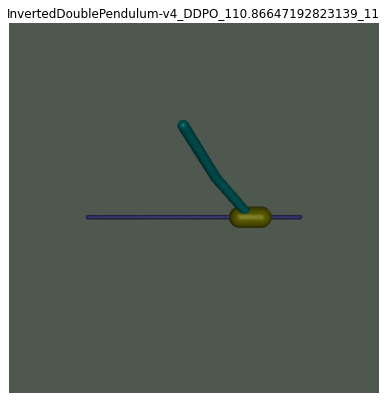

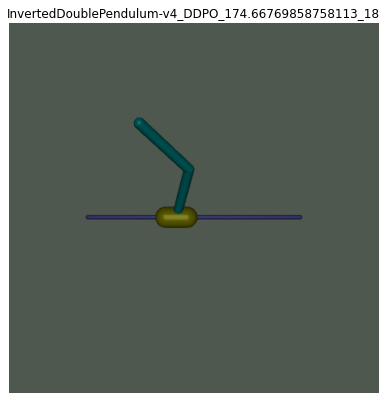

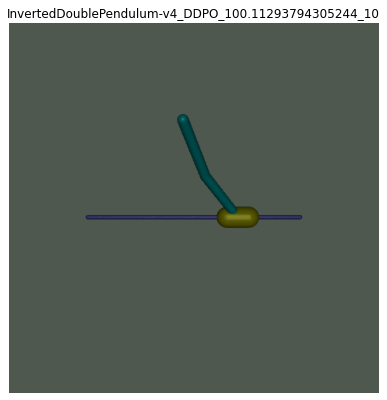

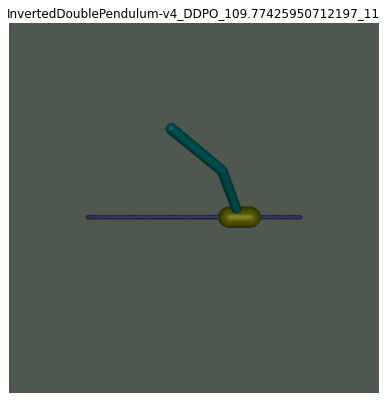

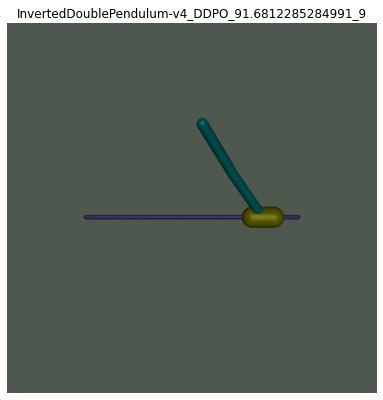

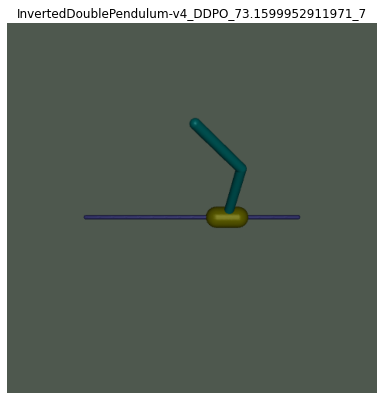

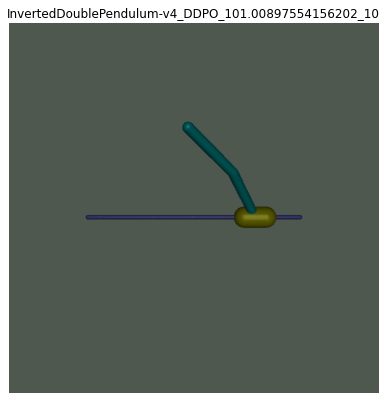

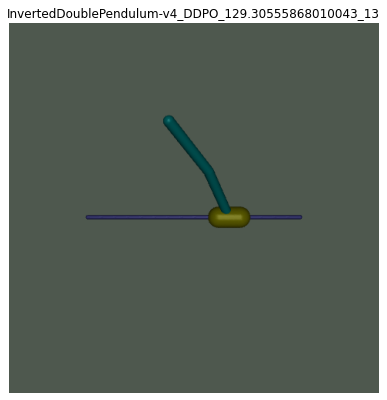

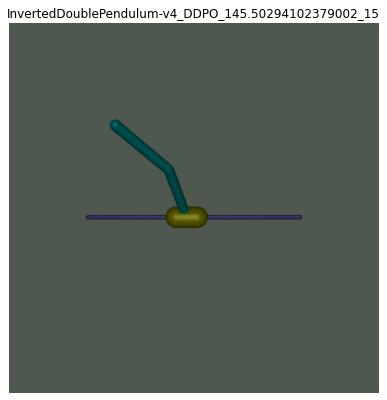

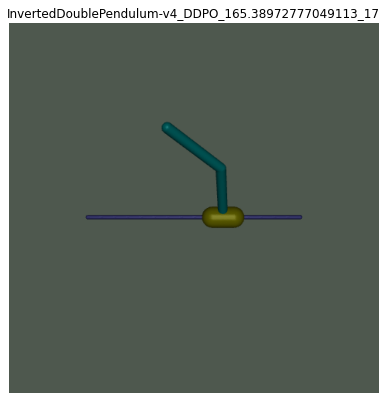

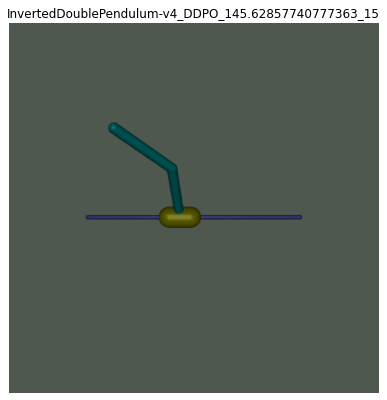

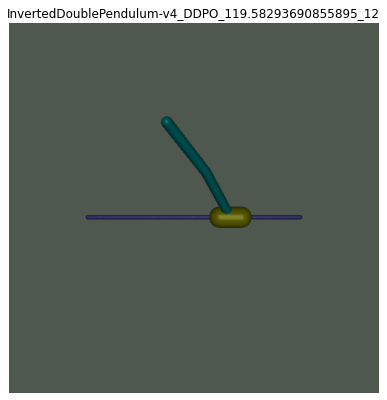

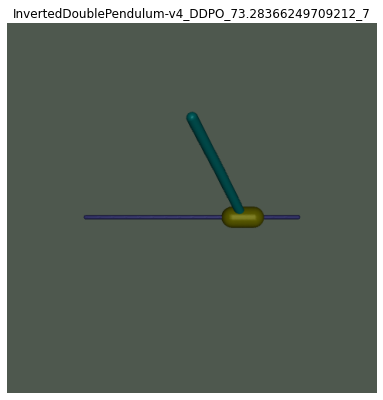

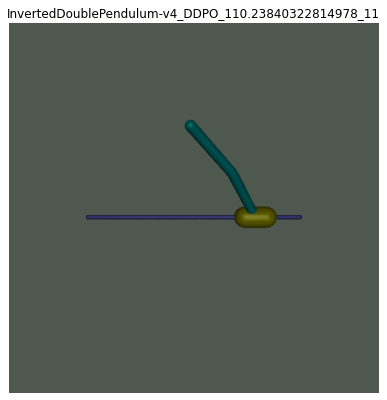

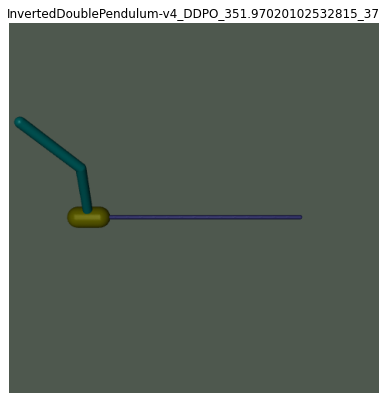

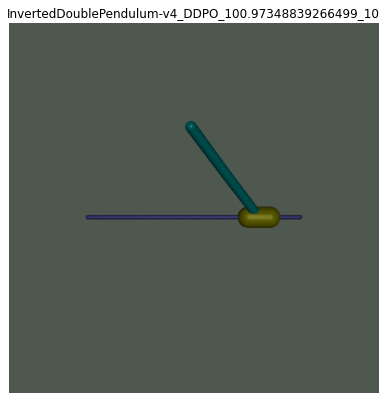

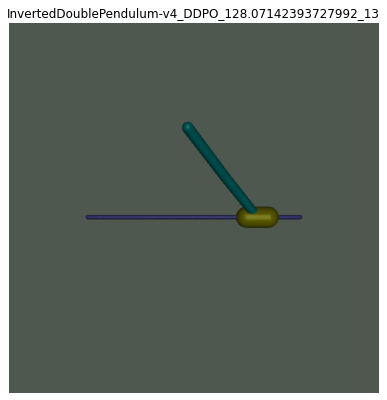

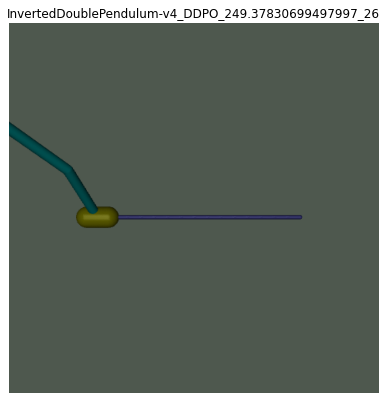

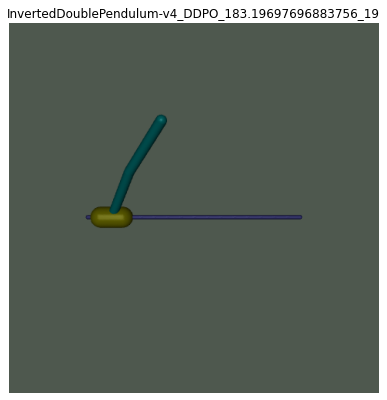

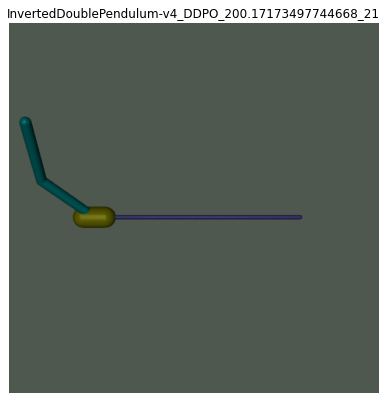

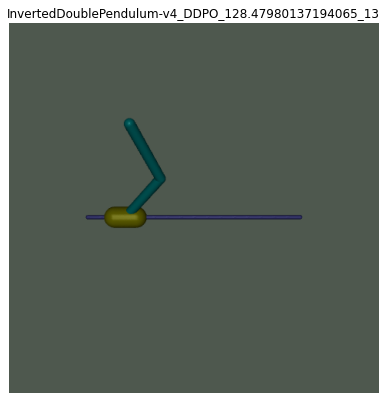

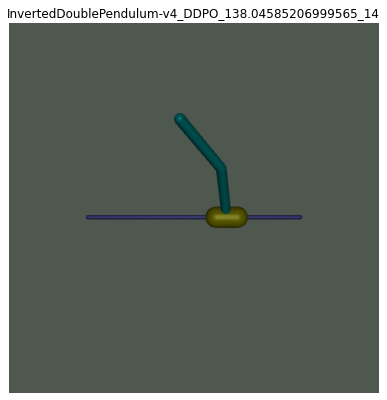

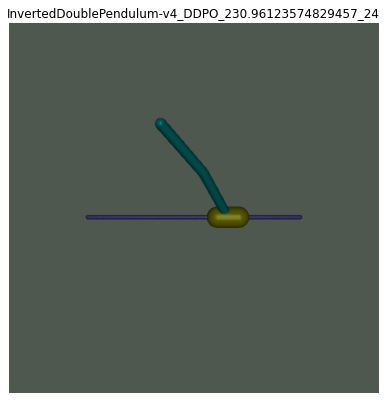

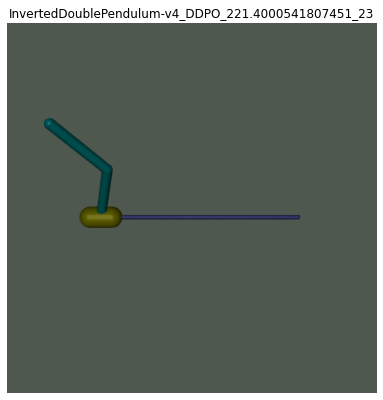

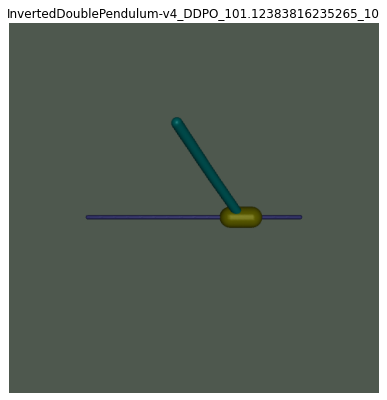

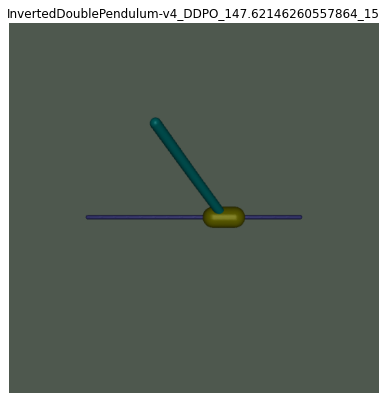

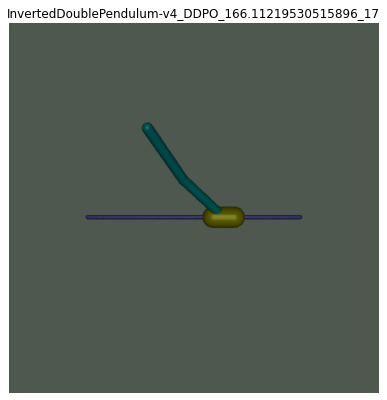

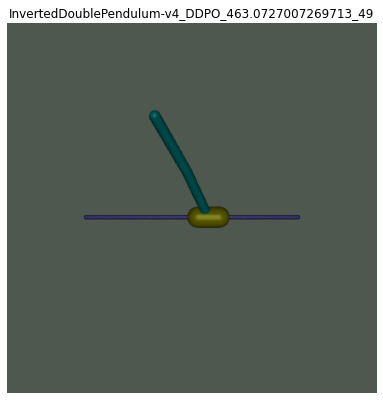

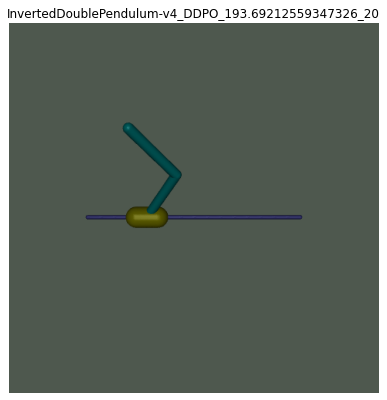

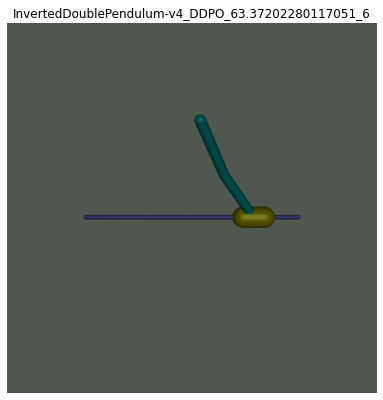

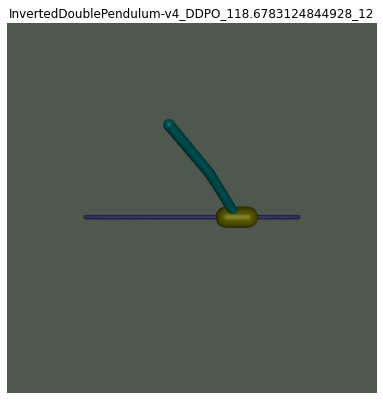

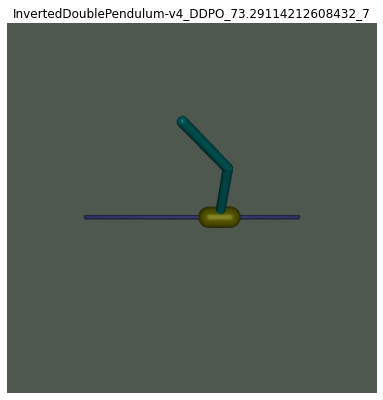

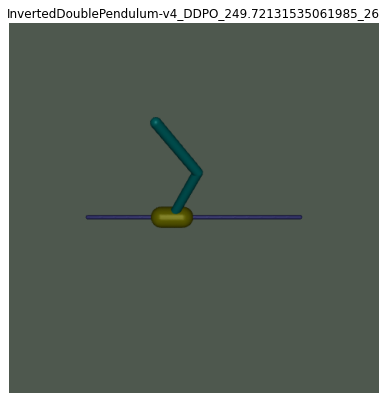

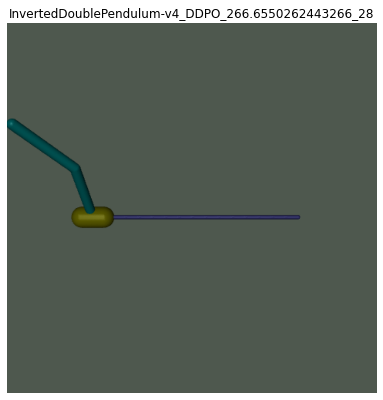

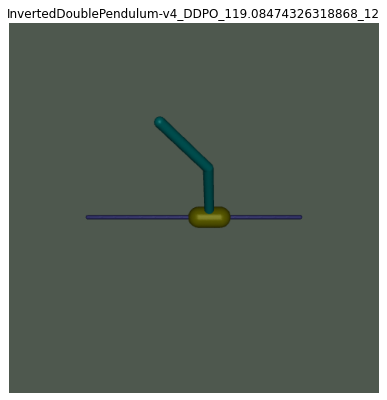

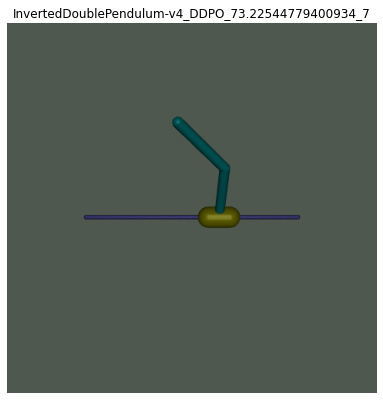

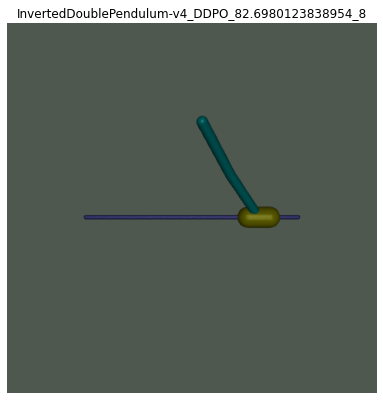

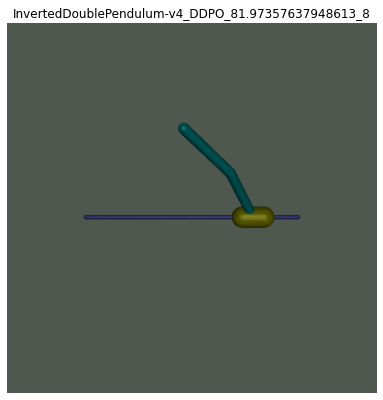

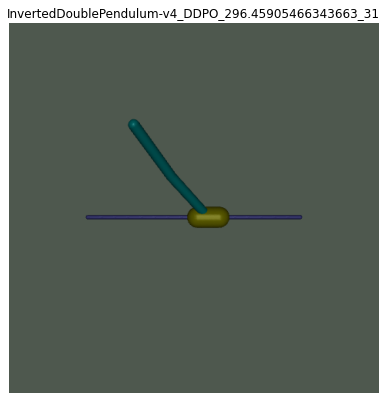

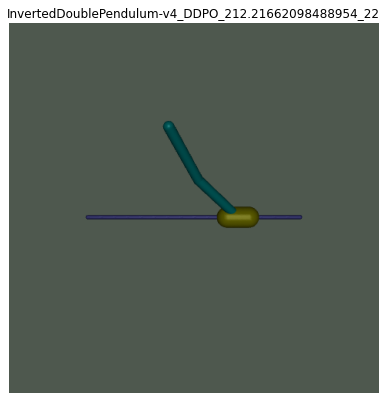

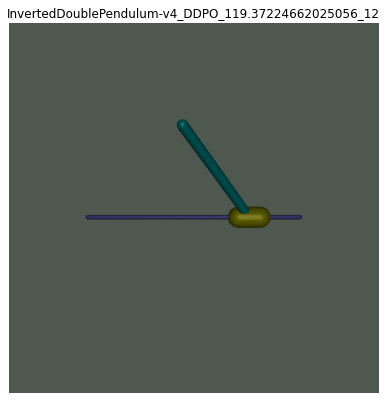

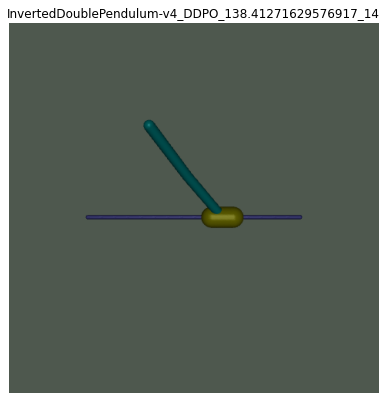

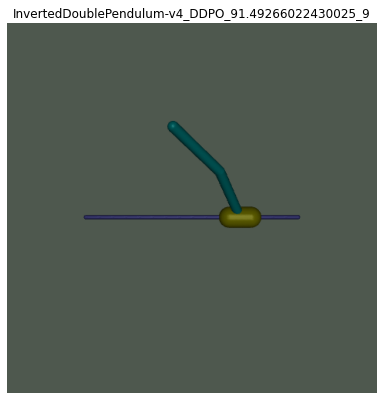

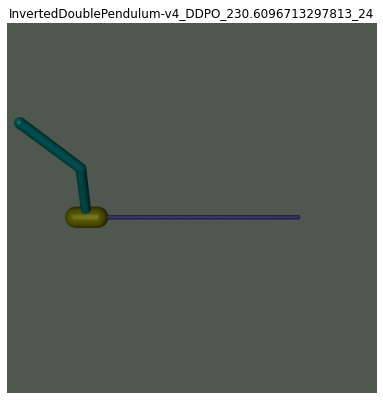

In [9]:
train(cfg)